In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import losses

# EDA

In [2]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_data.info

<bound method DataFrame.info of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...

In [5]:
train_data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

# PreProcessing

In [6]:
tweets = train_data['text'].to_numpy()
labels = train_data['target'].to_numpy()
tst_tweets = test_data['text']
trn_tweets, val_tweets, trn_labels, val_labels = train_test_split(tweets, labels, test_size=0.2, random_state=42, shuffle=True)

In [7]:
max_features = 20000
sequence_length = 200

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

2022-09-26 02:14:36.068425: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
vectorize_layer.adapt(trn_tweets)

2022-09-26 02:14:36.226791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [9]:
first_tweet = trn_tweets[0]
first_label = trn_labels[0]
print('Tweet', first_tweet)
print('Label', first_label)
print('Vectorized Tweet', vectorize_layer(trn_tweets[0]))

Tweet Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR
Label 1
Vectorized Tweet tf.Tensor(
[17198     8  4962  2917     6   156     5   438   216   118     4  2377
  4973  1177   240  4381  4119 14803     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0  

In [10]:
print('Word #17198 -->', vectorize_layer.get_vocabulary()[17198])
print('Word #8 -->', vectorize_layer.get_vocabulary()[8])
print('Word #4962 -->', vectorize_layer.get_vocabulary()[4962])
print('Total words in training vocabulary:', len(vectorize_layer.get_vocabulary()))

Word #17198 --> courageous
Word #8 --> and
Word #4962 --> honest
Total words in training vocabulary: 19422


In [11]:
embedding_layer = layers.Embedding(
    input_dim = max_features,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=sequence_length,
    name='mbedding_1')

In [12]:
Is = layers.Input(shape = (1,), dtype = tf.string)
L1 = vectorize_layer(Is)
L2 = embedding_layer(L1)
L3 = layers.GlobalAveragePooling1D()(L2)
Os = layers.Dense(1, activation = 'sigmoid')(L3)

model = tf.keras.Model(Is, Os, name = 'Dense_Model')
model.summary()

Model: "Dense_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 200)               0         
_________________________________________________________________
mbedding_1 (Embedding)       (None, 200, 128)          2560000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,560,129
Trainable params: 2,560,129
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)
history = model.fit(
    x=trn_tweets,
    y=trn_labels,
    epochs=15,
    validation_data=(val_tweets, val_labels)
)

Epoch 1/15
191/191 [==============================] - 6s 24ms/step - loss: 0.6814 - accuracy: 0.5695 - val_loss: 0.6755 - val_accuracy: 0.5739
Epoch 2/15
191/191 [==============================] - 4s 21ms/step - loss: 0.6675 - accuracy: 0.5739 - val_loss: 0.6662 - val_accuracy: 0.7768
Epoch 3/15
191/191 [==============================] - 4s 21ms/step - loss: 0.6366 - accuracy: 0.6598 - val_loss: 0.6269 - val_accuracy: 0.7610
Epoch 4/15
191/191 [==============================] - 4s 21ms/step - loss: 0.5849 - accuracy: 0.7568 - val_loss: 0.5837 - val_accuracy: 0.7879
Epoch 5/15
191/191 [==============================] - 4s 21ms/step - loss: 0.5253 - accuracy: 0.8130 - val_loss: 0.5441 - val_accuracy: 0.7899
Epoch 6/15
191/191 [==============================] - 4s 20ms/step - loss: 0.4706 - accuracy: 0.8425 - val_loss: 0.5181 - val_accuracy: 0.7925
Epoch 7/15
191/191 [==============================] - 4s 20ms/step - loss: 0.4263 - accuracy: 0.8565 - val_loss: 0.4964 - val_accuracy: 0.7965

In [14]:
model.evaluate(val_tweets, val_labels)

48/48 [==============================] - 0s 3ms/step - loss: 0.4583 - accuracy: 0.7978


[0.4583060145378113, 0.7977675795555115]

In [15]:
predictions = model.predict(val_tweets)
predictions = np.round(predictions).flatten()
print(predictions[:10])

[0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]


In [16]:
accuracy_score(y_true=val_labels, y_pred=predictions)

0.7977675640183848

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

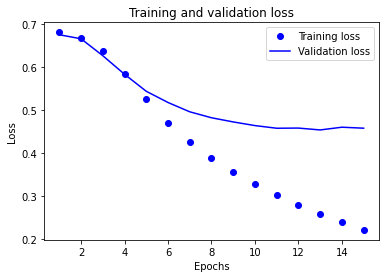

In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()